# Heart Disease Classification

## 1. Introduction

### 1.1 Background
Cardiovascular diseases (CVDs), especially heart disorders, are a primary cause of death worldwide, according to the World Health Organization. 

The aim of this project is to answer the following question: **Is heart disease present (values = 1, 2, 3, 4) or absent (value = 0) in a new patient?**

### 1.2 Data set
To answer this question, we will analyze data downloaded from the UCI Machine Learning Repository. Below, we compile four databases (Cleveland, Hungary, Switzerland, and VA Long Beach) into one dataset: `heart_disease_dataset`. Each row in the data set contains data about one patient. We will add a column `presence` (the predicted attribute) to indicate the presence or absence of heart disease. 

Relevant columns in the dataset:

- `age` - age in years
- `sex` - sex (1 = male; 0 = female)
- `cp` - chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
- `chol` - serum cholestoral in mg/dl
- `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- `restecg` - resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `thalach` - maximum heart rate achieved
- `exang` - exercise induced angina (1 = yes; 0 = no)
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- `ca` - number of major vessels (0-3) colored by flourosopy
- `thal` - 3 = normal; 6 = fixed defect; 7 = reversable defect
- `presence` - predicted attribute 

## 2. Preliminary exploratory data analysis


### 2.1 Loading libraries

In [6]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(GGally)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### 2.2 Reading, Cleaning, and Wrangling Data

- Assign column names "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "presence".
- Combine four data sets into one.
- Filter out any rows containing NA or invalid value.
- Select only `age`, `trestbps`, `chol`, `region`, `presence` (predicted attribute) columns.
- Shuffle rows of the data frame for a more representative randomly ordered data set.
- Represent `region` and `presence` as factors.


In [7]:
# Reading in data 
colnames <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "presence")

heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = colnames, na = c("?")) 

heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  presence = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2


In [8]:
# Assigning presence 1-4 to "yes" and presence 0 to "no"
heart_disease_data_no <- heart_disease_data %>%
                            filter(presence == "0") %>%
                            mutate(presence = "no")
heart_disease_data_yes <- heart_disease_data %>%
                            filter(presence != "0") %>%
                            mutate(presence = "yes")

heart_disease_data <- rbind(heart_disease_data_no, heart_disease_data_yes)
heart_disease_data <- heart_disease_data %>%
                        mutate(presence = as.factor(presence))

heart_disease_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,no
37,1,3,130,250,0,0,187,0,3.5,3,0,3,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3,no
56,1,2,120,236,0,0,178,0,0.8,1,0,3,no
57,0,4,120,354,0,0,163,1,0.6,1,0,3,no
57,1,4,140,192,0,0,148,0,0.4,2,0,6,no
56,0,2,140,294,0,2,153,0,1.3,2,0,3,no
44,1,2,120,263,0,0,173,0,0.0,1,0,7,no
52,1,3,172,199,1,0,162,0,0.5,1,0,7,no


In [9]:
# all NA have been dropped, selecting a subset of non-categorical and predicted attribute

heart_disease_data <- heart_disease_data %>% drop_na() # drop any rows with NA (removes 303 - 6 = 297 rows)

cat("Heart disease data set after dropping all NA has ", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns")

heart_disease_data <- mutate_at(heart_disease_data, vars(presence), factor) # create a new col presence to df
# select non-categorical possible predictor variable columns, and predicted attribute "presence"
heart_disease_data <- heart_disease_data %>% select(age, trestbps, chol, thalach, oldpeak, presence) # select only these attributes because rest are categorical variables 

heart_disease_data 

Heart disease data set after dropping all NA has  297 rows and 14 columns

age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,no
37,130,250,187,3.5,no
41,130,204,172,1.4,no
56,120,236,178,0.8,no
57,120,354,163,0.6,no
57,140,192,148,0.4,no
56,140,294,153,1.3,no
44,120,263,173,0.0,no
52,172,199,162,0.5,no


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



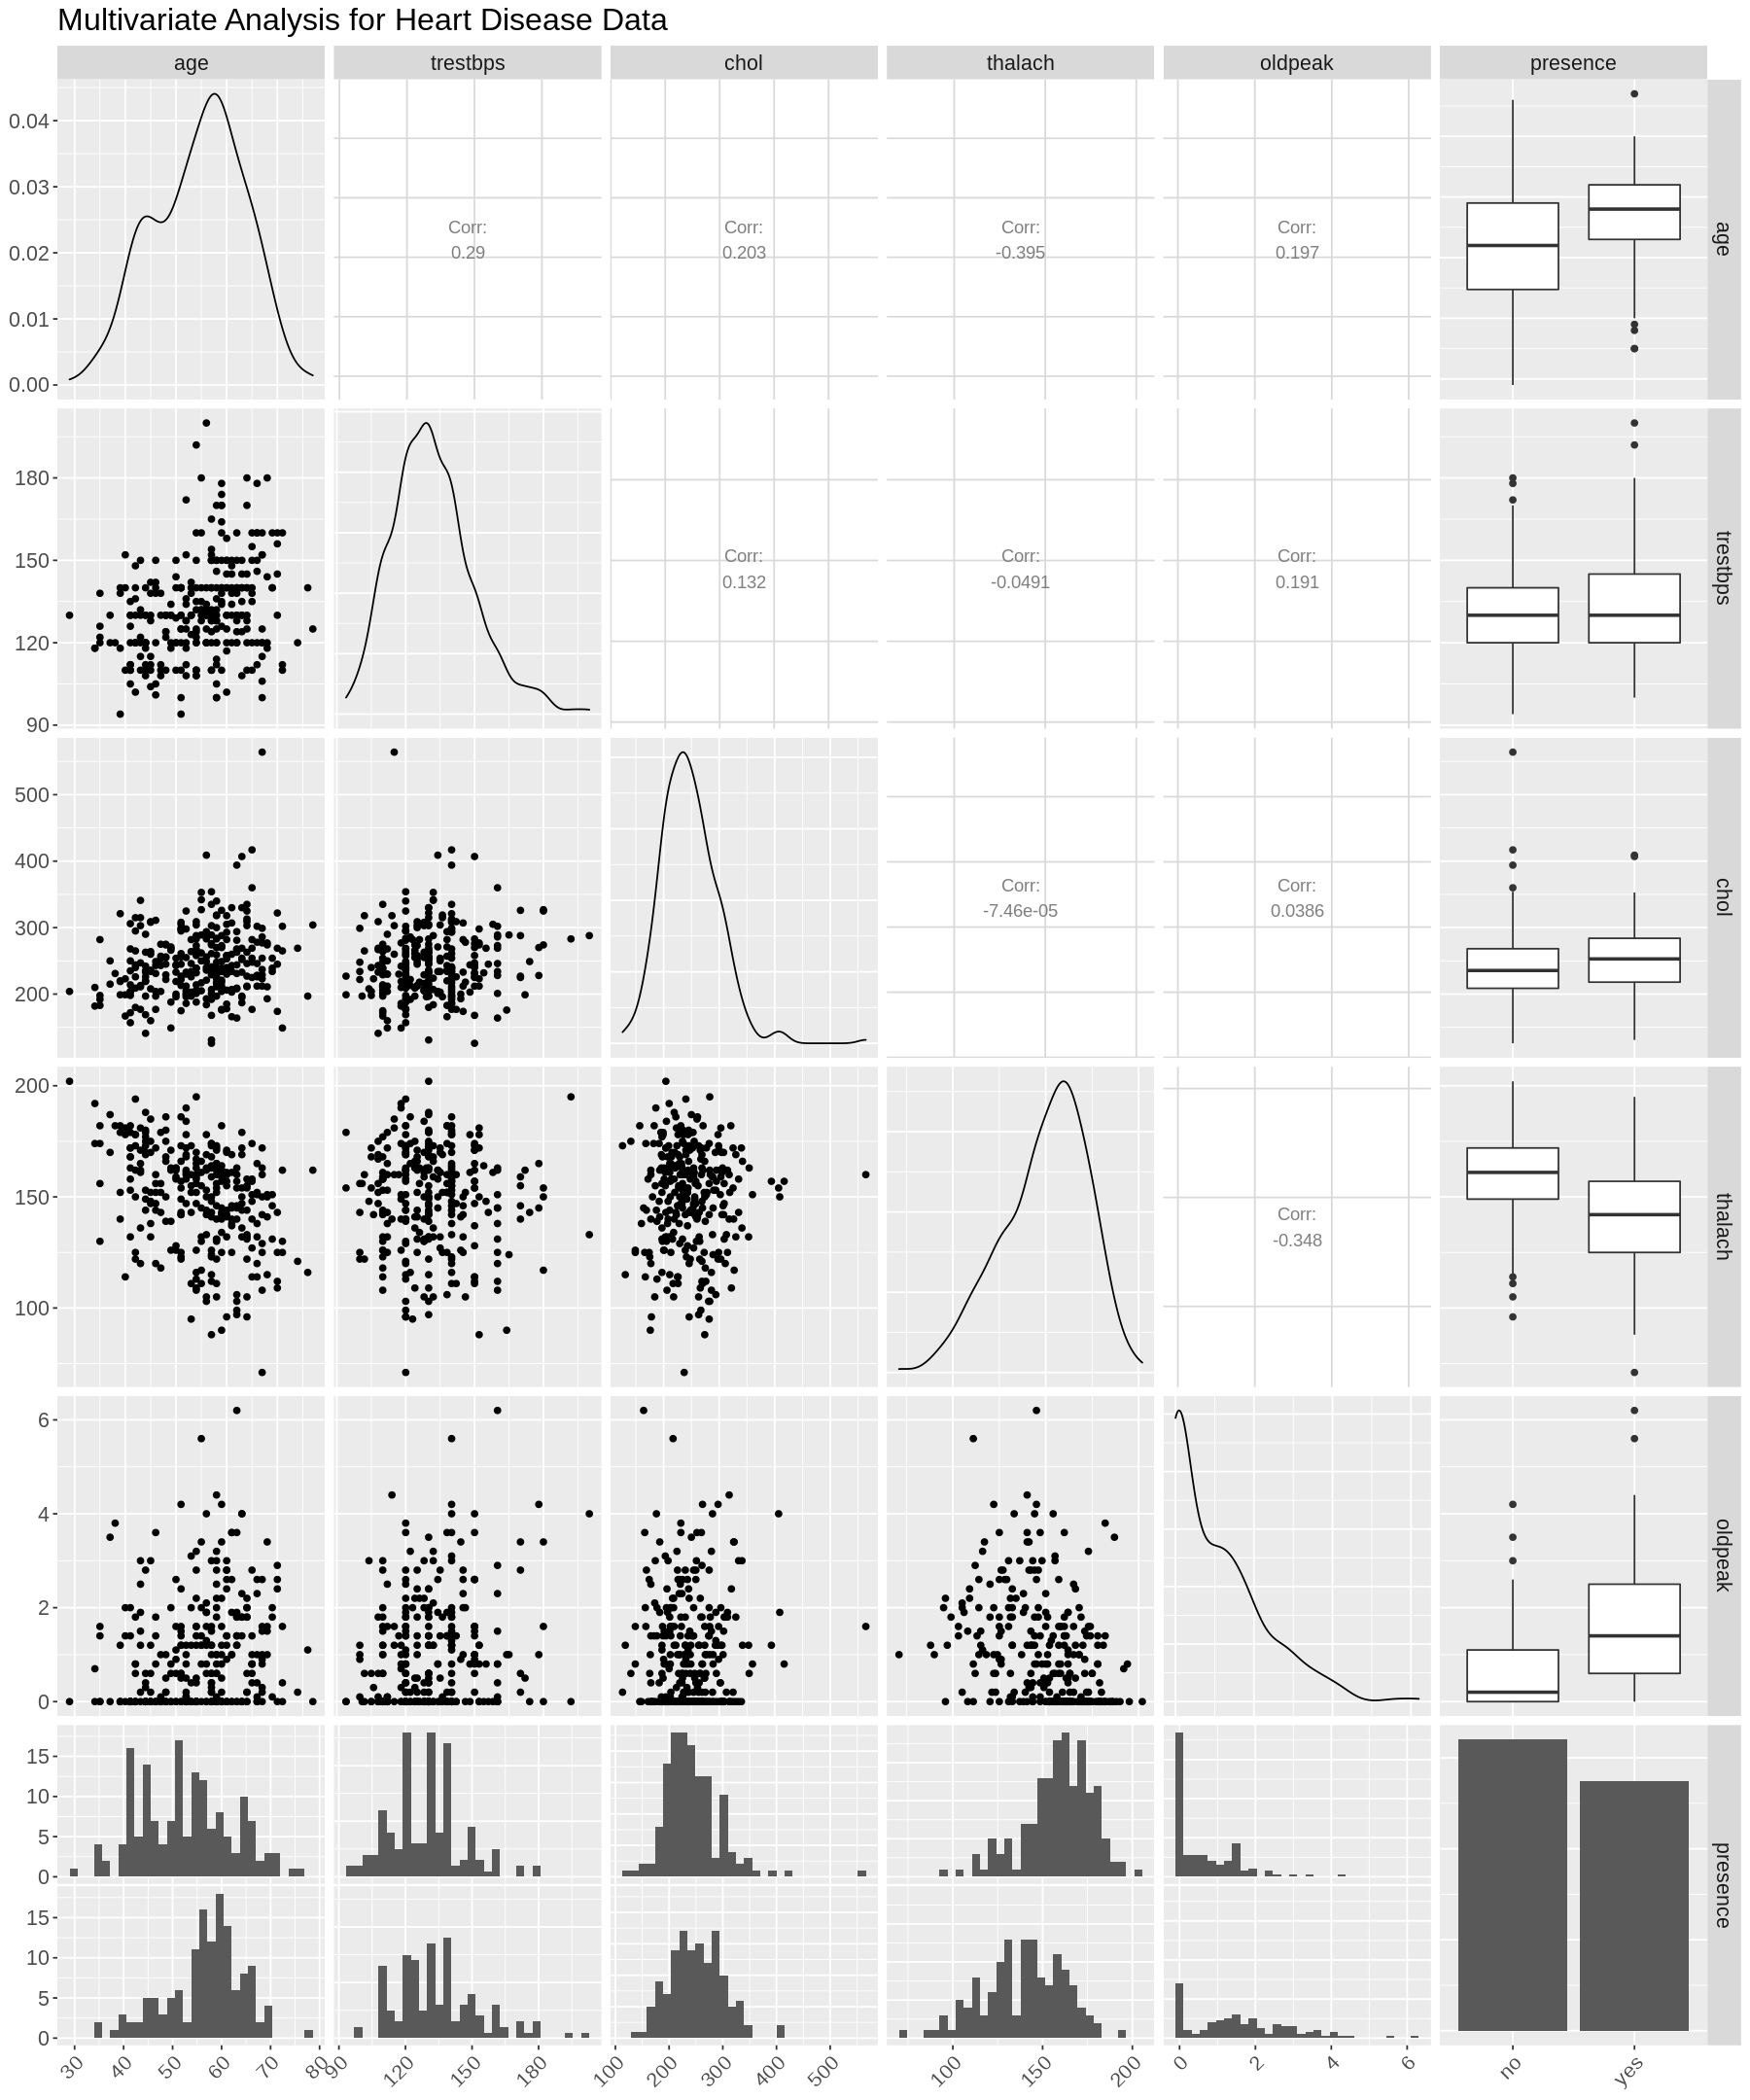

In [10]:
options(repr.plot.width = 15, repr.plot.height = 18)

#scatterplot matrix (ggpairs) with all categorical variables
multivariate_plot <- heart_disease_data %>%
    ggpairs() +  
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(text = element_text(size = 16)) +
    ggtitle("Multivariate Analysis for Heart Disease Data")

multivariate_plot 

In [11]:
# Shuffling rows of the data frame so that they are no longer ordered by region and are randonly ordered
set.seed(999) # reproducible
rand_order <- sample(nrow(heart_disease_data)) # random ordering
heart_disease_data <- heart_disease_data[rand_order,] # shuffle the rows of the data frame

head(heart_disease_data) # view first few rows 
heart_disease_data # view entire data set 
cat("Heart disease data set after pre-processing has", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns")

age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
54,108,309,156,0.0,no
51,94,227,154,0.0,no
67,106,223,142,0.3,no
51,130,305,142,1.2,yes
57,150,168,174,1.6,no
71,112,149,125,1.6,no


age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
54,108,309,156,0.0,no
51,94,227,154,0.0,no
67,106,223,142,0.3,no
51,130,305,142,1.2,yes
57,150,168,174,1.6,no
71,112,149,125,1.6,no
63,124,197,136,0.0,yes
61,140,207,138,1.9,yes
61,120,260,140,3.6,yes


Heart disease data set after pre-processing has 297 rows and 6 columns

### 2.2 Splitting & Summarizing data

We will be partitioning `heart_disease_data` into a training (75%) and testing (25%) set using the `tidymodels` package. We will then find the best k-nn classifier using the training set and evaluate the performance of our model on the test dataset. We will use the variable `presence` as our class label. 

#### Summary Statistics (only using training data)
- Count the number of patients with presence = 0 (heart disease absent), and presence = 1-4 (heart disease present)
- Calculate the summary statistics  mean, median, standard deviation, max, min for the numerical variables age, chol, trestbps.
- No missing data in the dataset.

In [13]:
heart_disease_data_split <- initial_split(heart_disease_data, prop = 3/4, strata = presence)  
heart_disease_data_train <- training(heart_disease_data_split)   
heart_disease_data_test <- testing(heart_disease_data_split)

# heart_disease_data_train
# dim(heart_disease_data_train)

# heart_disease_data_test
# dim(heart_disease_data_test)

count_by_presence <- heart_disease_data_train %>%
                      group_by(presence) %>%
                      summarise(count = n())

count_by_presence 

# select the numerical columns of age, chol, trestbps
heart_disease_data_train_num <- heart_disease_data_train %>% select(-presence)

# heart_disease_data_train 

# Data Summary Table

heart_disease_data_mean <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, mean))
heart_disease_data_median <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, median))
heart_disease_data_max <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, max))
heart_disease_data_min <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, min))
heart_disease_data_sd <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, sd))
    
heart_disease_data_max = heart_disease_data_max %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "max"
    )

heart_disease_data_min = heart_disease_data_min %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "min"
    )

heart_disease_data_mean = heart_disease_data_mean %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "mean"
    )

heart_disease_data_median = heart_disease_data_median %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "median"
    )

heart_disease_data_sd = heart_disease_data_sd %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "standard_deviation"
    )

heart_disease_data_table <- merge(heart_disease_data_max, heart_disease_data_min, by = 'variable') %>% 
                            merge(heart_disease_data_mean, by = 'variable') %>% 
                            merge(heart_disease_data_median,by = 'variable') %>%
                            merge(heart_disease_data_sd, by = 'variable')
heart_disease_data_table


`summarise()` ungrouping output (override with `.groups` argument)



presence,count
<fct>,<int>
no,120
yes,103


variable,max,min,mean,median,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,77.0,29,54.103139,55.0,8.723125
chol,564.0,131,248.600897,244.0,51.838257
oldpeak,6.2,0,1.050673,0.8,1.146120
thalach,202.0,71,150.219731,154.0,22.680928
trestbps,200.0,94,132.596413,130.0,17.912912


### 2.3 Visualization (using training data)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



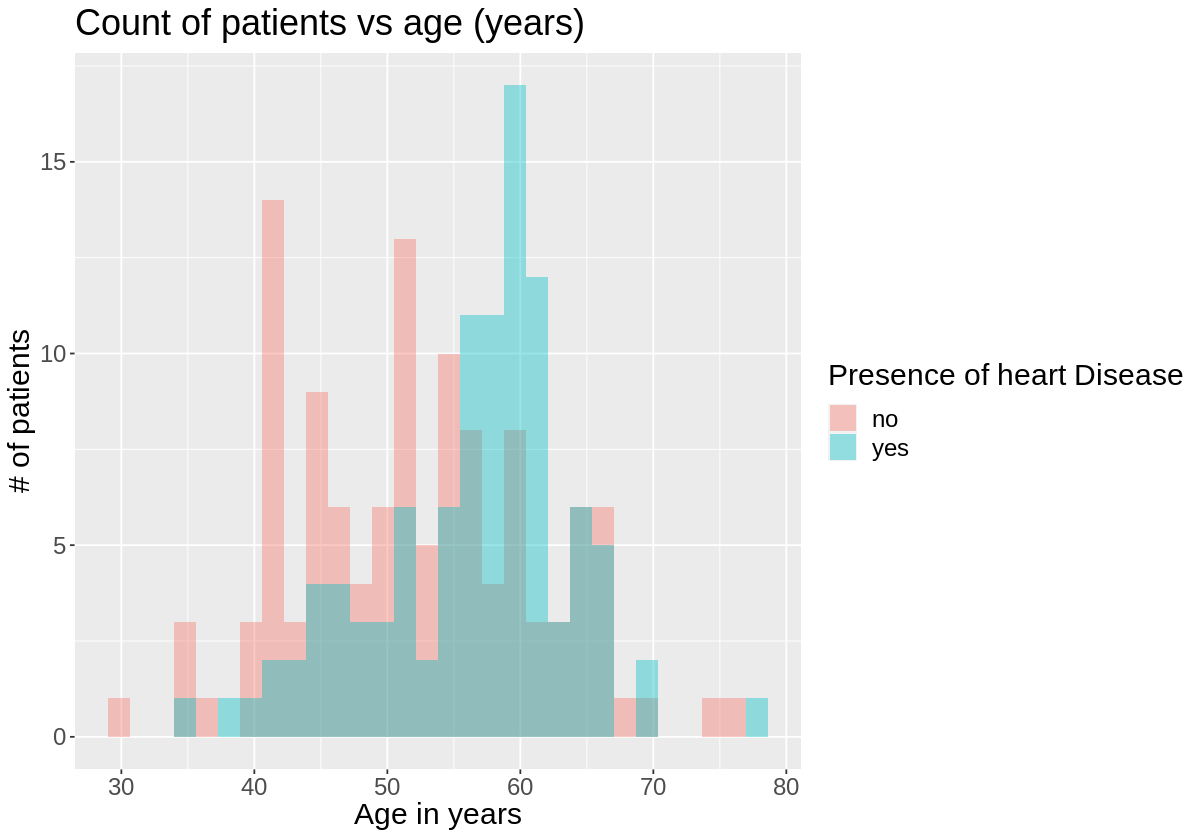

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



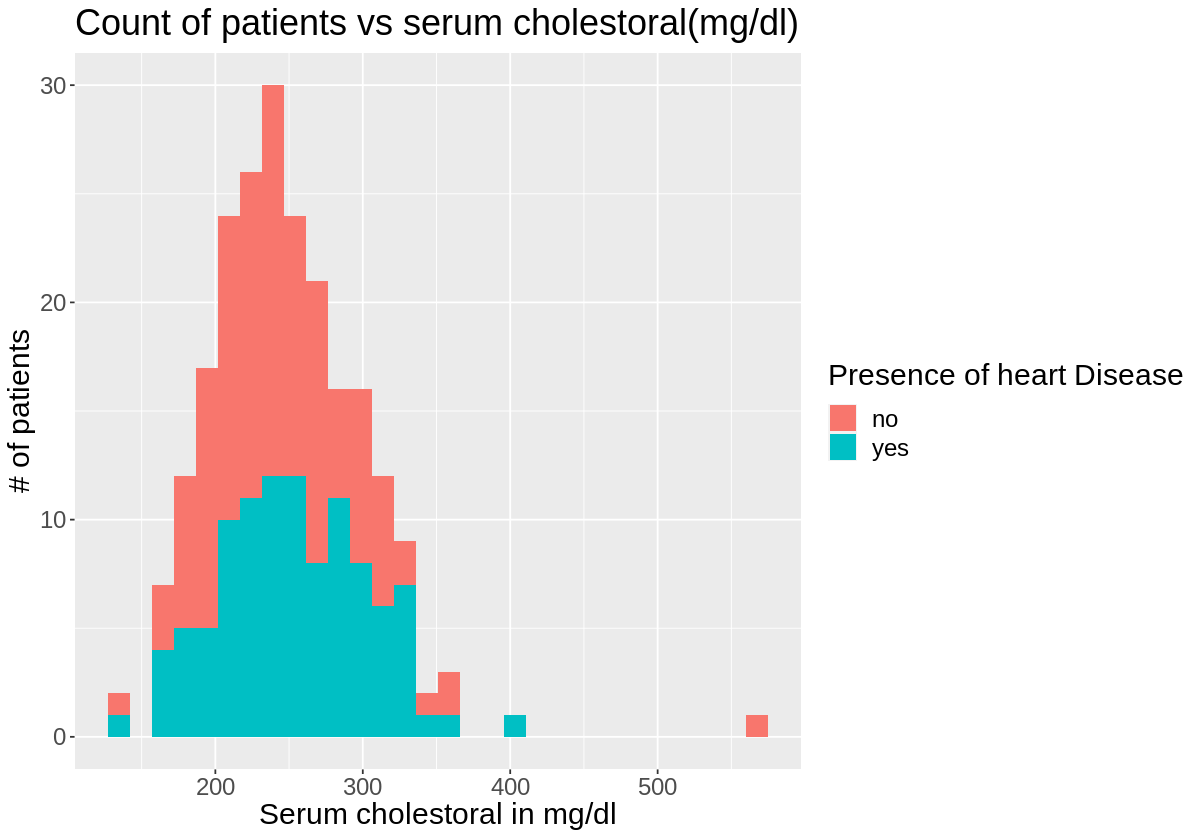

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



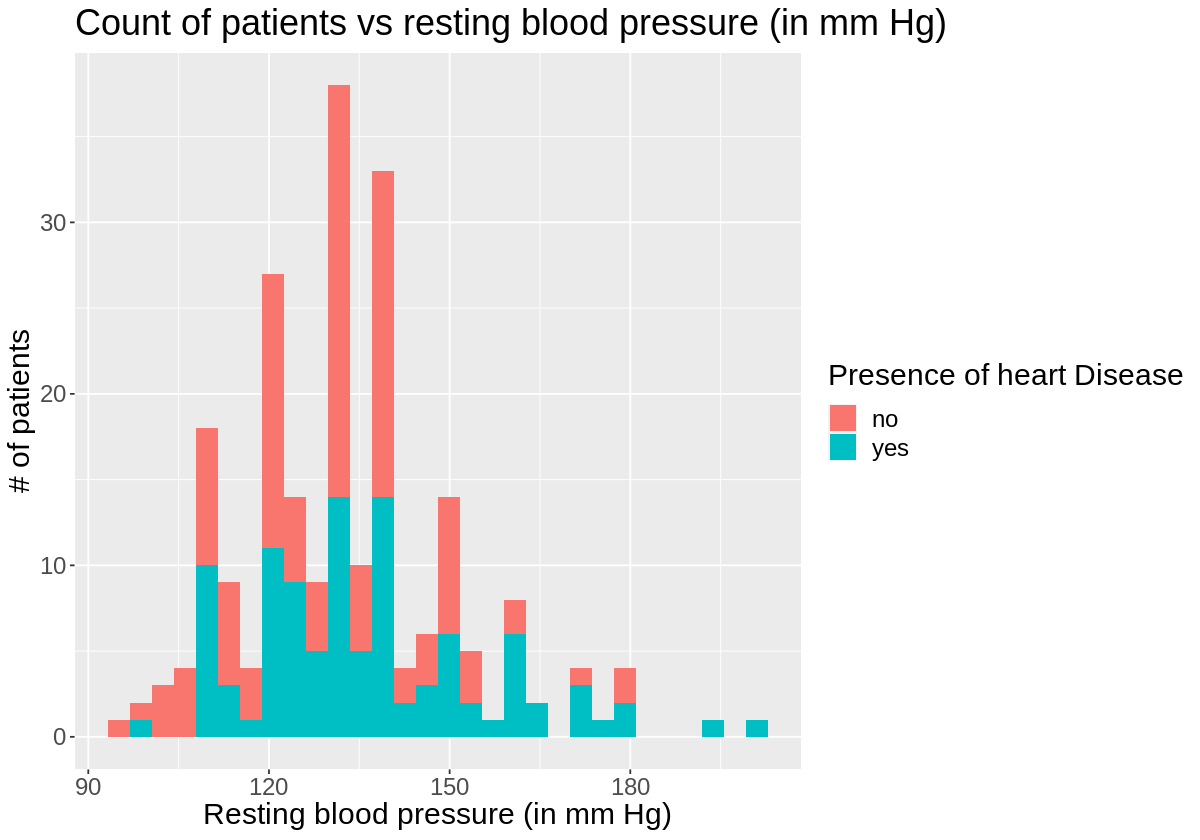

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



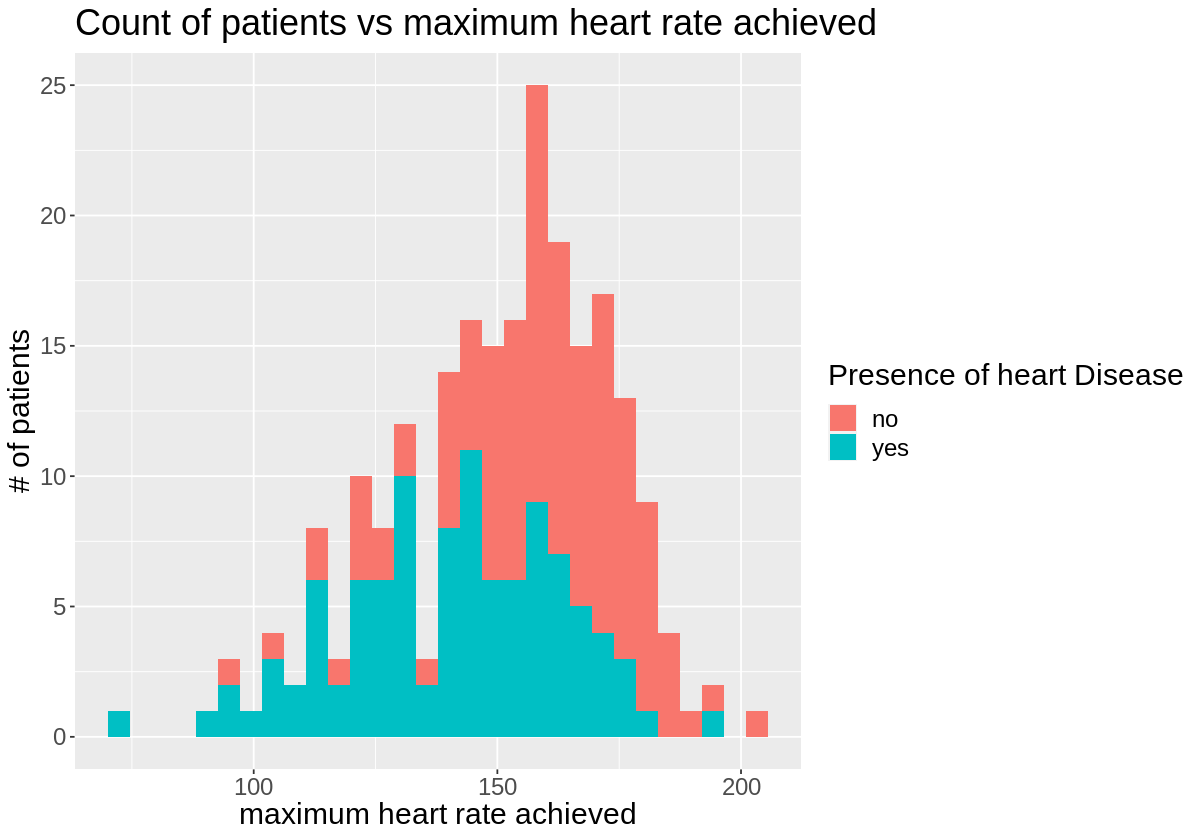

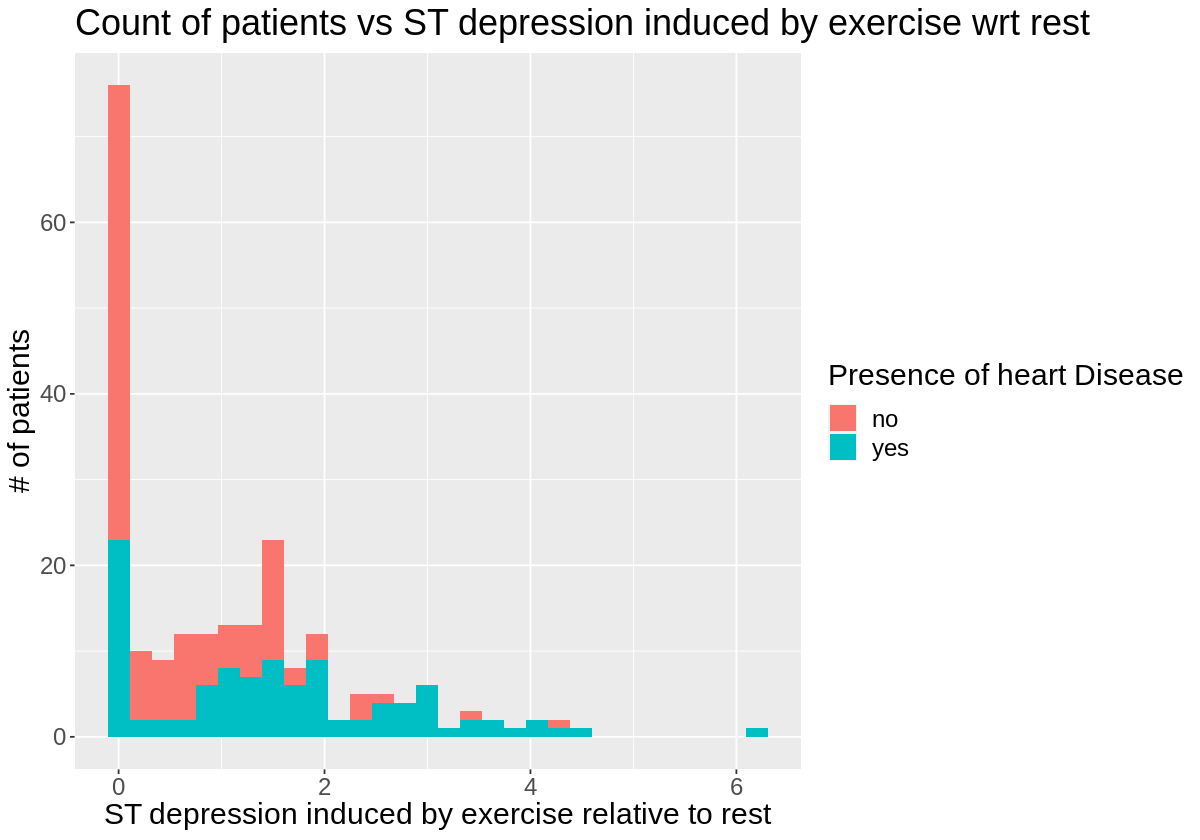

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Presence/absence based on age
heart_disease_data_train_age_plot <- ggplot(heart_disease_data_train, aes(x = age)) +
                                    geom_histogram(aes(fill = presence), alpha=0.5, position="identity") +
                                    labs(x = "Age in years", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Count of patients vs age (years)")
heart_disease_data_train_age_plot

# Presence/absence based on cholestrol
heart_disease_data_train_chol_plot <- ggplot(heart_disease_data_train, aes(x = chol)) +
                                    geom_histogram(aes(fill = presence)) +
                                    labs(x = "Serum cholestoral in mg/dl", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Count of patients vs serum cholestoral(mg/dl)")
heart_disease_data_train_chol_plot


# Presence/absence based on resting blood pressure
heart_disease_data_train_trestbps_plot <- ggplot(heart_disease_data_train, aes(x = trestbps)) +
                                    geom_histogram(aes(fill = presence)) +
                                    labs(x = "Resting blood pressure (in mm Hg)", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Count of patients vs resting blood pressure (in mm Hg)")
heart_disease_data_train_trestbps_plot

# Presence/absence based on resting blood pressure
heart_disease_data_train_thalach_plot <- ggplot(heart_disease_data_train, aes(x = thalach)) +
                                    geom_histogram(aes(fill = presence)) +
                                    labs(x = "maximum heart rate achieved", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Count of patients vs maximum heart rate achieved")
heart_disease_data_train_thalach_plot

# Presence/absence based on resting blood pressure
heart_disease_data_train_oldpeak_plot <- ggplot(heart_disease_data_train, aes(x = oldpeak)) +
                                    geom_histogram(aes(fill = presence)) +
                                    labs(x = "ST depression induced by exercise relative to rest", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Count of patients vs ST depression induced by exercise wrt rest")
heart_disease_data_train_oldpeak_plot

## 3. Methods

### 3.1 Analysis and Variables
Many physiological attributes have been shown through studies and reports by the CDC and WHO to have strong links to heart disease. After examining the data and filtering out categorical variables, we have chosen the three most relevant out of the five numerical values in our dataset to analyze: trestbps (resting blood pressure), chol (serum cholesterol in mg/dl), and age (age in years). Using our chosen variables, we will construct and test a classifier using the KNN classification model and choose an appropriate k using cross-validation.

### 3.2 Visualization of Results
We will visualize results of our classification using different plots to indicate the relationships among all of the variables. This includes plotting each predictor against each other and colouring based on presence to show the relationship and line graphs to determine what number of k neighbours we will use.

## 4. Expected outcomes and significance

### 4.1 Expected Findings
We should be able to predict the presence or absence of heart disease in new patients by training and testing our model with good accuracy.

### 4.2 Possible Impacts
- Using our model, patients can be classified as high or low risk for heart disease using their cholesterol, blood pressure, and age.
- Early diagnosis of heart disease based on this classification can help save more lives by allowing patients to make lifestyle adjustments or seek medical assistance sooner.


### 4.3 Future Questions
- Are there other factors not included in this dataset which could be important in predicting presence of heart disease?
- If more factors are considered, would it improve accuracy of the model?
